```
Topic:        Project 5
Subject:      Interpreting Gender and Emotion from Speech Audio
Date:         09/11/2020
Name:         David Weon

Notebook has been cleaned using nbextension 'Code prettify'
```

# Exploratory Data Analysis

## Data Import

In [1]:
# keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# other
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd

**Filename identifiers**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only)
* Vocal channel (01 = speech, 02 = song)
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door")
* Repetition (01 = 1st repetition, 02 = 2nd repetition)
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female)

In [2]:
#local directory of audio files
RAV = "/Users/davidweon/davids_repo/projects/project5_speech_emotion/src/data/emotion_audio_archive/audio_speech_actors_01-24/"

## Data Clean

In [3]:
#call files in directory
dir_list = os.listdir(RAV)
dir_list.sort()
dir_list.remove('.DS_Store')

In [4]:
#separate out emotion and gender based on filename identifiers
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp % 2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

In [5]:
#create dataframe of gender_emotion labels
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({
    1: 'neutral',
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
})
RAV_df = pd.concat([pd.DataFrame(gender), RAV_df], axis=1)
RAV_df.columns = ['gender', 'emotion']
RAV_df['labels'] = RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path, columns=['path'])], axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)

## Data Check

In [6]:
RAV_df.head()

,labels,source,path
0,male_surprise,RAVDESS,/Users/davidweon/davids_repo/projects/project5...
1,male_surprise,RAVDESS,/Users/davidweon/davids_repo/projects/project5...
2,male_angry,RAVDESS,/Users/davidweon/davids_repo/projects/project5...
3,male_fear,RAVDESS,/Users/davidweon/davids_repo/projects/project5...
4,male_fear,RAVDESS,/Users/davidweon/davids_repo/projects/project5...


In [7]:
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
female_surprise     96
female_disgust      96
female_happy        96
male_surprise       96
male_sad            96
female_angry        96
male_happy          96
male_angry          96
male_fear           96
female_fear         96
female_sad          96
male_disgust        96
Name: labels, dtype: int64

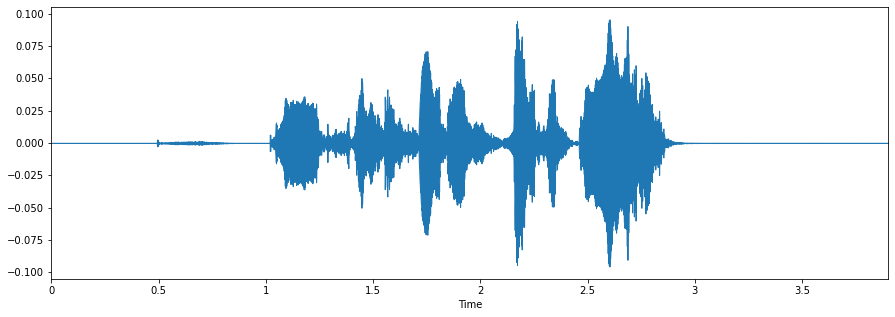

In [25]:
#test out an example "sad" audio file:
#03 (audio-only), 01 (speech), 04 (sad), etc
fname = RAV + 'Actor_14/03-01-04-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)

#plot the audio waveform
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
# plt.savefig('female_sad.jpg', dpi=500)

#play the audio
ipd.Audio(fname)

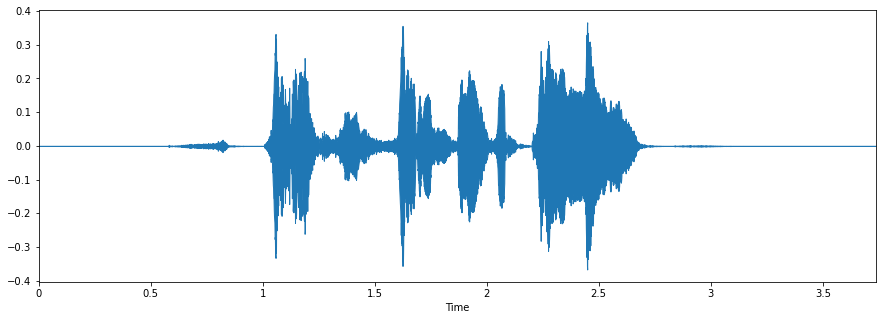

In [26]:
#test out an example "happy" audio file:
#03 (audio-only), 01 (speech), 03 (happy), etc
fname = RAV + 'Actor_14/03-01-03-02-02-02-14.wav'
data, sampling_rate = librosa.load(fname)

#plot the audio waveform
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
# plt.savefig('female_happy.jpg', dpi=500)

#play the audio
ipd.Audio(fname)

# Base Model

## Data Preparation

In [11]:
total_df = pd.DataFrame(columns=['feature'])

#loop feature extraction over the entire dataset
counter = 0
for index, path in enumerate(RAV_df.path):
    X, sample_rate = librosa.load(path,
                                  res_type='kaiser_fast',
                                  duration=2.5,
                                  sr=44100,
                                  offset=0.5)
    sample_rate = np.array(sample_rate)

    # mean as the feature
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),
                    axis=0)
    total_df.loc[counter] = [mfccs]
    counter = counter + 1

#check for successful processing
print(len(total_df))
total_df.head()

1440


,feature
0,"[-61.862373, -61.862373, -61.862373, -61.86237..."
1,"[-61.507996, -61.507996, -61.507996, -61.50799..."
2,"[-55.663086, -56.170334, -56.157845, -54.66347..."
3,"[-63.523525, -63.523525, -63.523525, -63.52352..."
4,"[-43.19739, -44.238605, -43.996212, -44.13236,..."


In [12]:
#merge labels with its features
total_df = pd.concat(
    [RAV_df, pd.DataFrame(total_df['feature'].values.tolist())], axis=1)
total_df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_surprise,RAVDESS,/Users/davidweon/davids_repo/projects/project5...,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,-61.862373,...,-61.862373,-61.862373,-61.761398,-60.348404,-60.160458,-61.384304,-60.519127,-61.495956,-61.862373,-60.531559
1,male_surprise,RAVDESS,/Users/davidweon/davids_repo/projects/project5...,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,...,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996,-61.507996
2,male_angry,RAVDESS,/Users/davidweon/davids_repo/projects/project5...,-55.663086,-56.170334,-56.157845,-54.663475,-55.166775,-56.156944,-56.156944,...,-55.155067,-56.156944,-56.156944,-56.156944,-55.844219,-56.156944,-56.156944,-56.156944,-56.156944,-56.156944
3,male_fear,RAVDESS,/Users/davidweon/davids_repo/projects/project5...,-63.523525,-63.523525,-63.523525,-63.523525,-63.523525,-63.377365,-61.595852,...,-39.336517,-39.847824,-40.466042,-40.448078,-42.883072,-43.367554,-46.280293,-48.273811,-49.745174,-50.472908
4,male_fear,RAVDESS,/Users/davidweon/davids_repo/projects/project5...,-43.197392,-44.238605,-43.996212,-44.132359,-44.267864,-44.346043,-44.142902,...,-32.987087,-33.476284,-33.367661,-32.961876,-31.957905,-31.085176,-31.186022,-30.768852,-19.886078,-12.408971


In [13]:
#fill na with 0
total_df = total_df.fillna(0)

## Data Processing

In [16]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(total_df.drop(
    ['path', 'labels', 'source'], axis=1),
                                                    total_df.labels,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

## Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
#random forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_predict_rf = rfc.predict(X_test)

In [19]:
print(classification_report(y_test, y_predict_rf))

                 precision    recall  f1-score   support

   female_angry       0.41      0.39      0.40        23
 female_disgust       0.41      0.55      0.47        22
    female_fear       0.35      0.52      0.42        21
   female_happy       0.22      0.17      0.19        24
 female_neutral       0.52      0.76      0.62        42
     female_sad       0.37      0.22      0.27        32
female_surprise       0.52      0.54      0.53        26
     male_angry       0.62      0.52      0.57        29
   male_disgust       0.29      0.28      0.29        18
      male_fear       0.39      0.29      0.33        24
     male_happy       0.40      0.15      0.22        26
   male_neutral       0.36      0.69      0.48        29
       male_sad       0.00      0.00      0.00        26
  male_surprise       0.33      0.44      0.38        18

       accuracy                           0.41       360
      macro avg       0.37      0.39      0.37       360
   weighted avg       0.38   

# Neural Network

In [15]:
#normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train_nn = (X_train - mean) / std
X_test_nn = (X_test - mean) / std

In [32]:
#keras formatting
X_train_nn = np.array(X_train_nn)
y_train_nn = np.array(y_train_nn)
X_test_nn = np.array(X_test_nn)
y_test_nn = np.array(y_test_nn)

#one hot encode the target
lb = LabelEncoder()
y_train_nn = np_utils.to_categorical(lb.fit_transform(y_train_nn))
y_tes_nnt = np_utils.to_categorical(lb.fit_transform(y_test_nn))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

#pickle labels
# filename = 'emotion_speech_labels'
# outfile = open(filename, 'wb')
# pickle.dump(lb, outfile)
# outfile.close()

(1080, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [33]:
#expanding dimension for CNN
X_train_nn = np.expand_dims(X_train_nn, axis=2)
X_test_nn = np.expand_dims(X_test_nn, axis=2)
X_train_nn.shape

(1080, 216, 1)

## Model Creation

In [34]:
#creating 1D convolutional neural network
model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(X_train_nn.shape[1], 1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14))  #target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 216, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 256)           0

In [99]:
#adding early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [100]:
#run model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_history = model.fit(X_train_nn,
                          y_train_nn,
                          batch_size=16,
                          epochs=200,
                          validation_data=(X_test_nn, y_test_nn),
                          callbacks=[es])

Epoch 1/200
68/68 [==============================] - 11s 161ms/step - loss: 0.0673 - accuracy: 0.9963 - val_loss: 1.3901 - val_accuracy: 0.5417
Epoch 2/200
68/68 [==============================] - 12s 183ms/step - loss: 0.0638 - accuracy: 1.0000 - val_loss: 1.4232 - val_accuracy: 0.5194
Epoch 3/200
68/68 [==============================] - 14s 200ms/step - loss: 0.0602 - accuracy: 1.0000 - val_loss: 1.4237 - val_accuracy: 0.5278
Epoch 4/200
68/68 [==============================] - 14s 212ms/step - loss: 0.0663 - accuracy: 0.9981 - val_loss: 1.4011 - val_accuracy: 0.5222
Epoch 5/200
68/68 [==============================] - 15s 218ms/step - loss: 0.0611 - accuracy: 0.9991 - val_loss: 1.4105 - val_accuracy: 0.5333
Epoch 6/200
68/68 [==============================] - 16s 229ms/step - loss: 0.0549 - accuracy: 1.0000 - val_loss: 1.3980 - val_accuracy: 0.5333
Epoch 7/200
68/68 [==============================] - 18s 263ms/step - loss: 0.0539 - accuracy: 0.9981 - val_loss: 1.4226 - val_accuracy:

## Model Serialization

In [102]:
# #save model and weights
# model_name = 'cnn_model_weights.h5'
# save_dir = os.path.join(os.getcwd(), 'saved_models')

# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Save model and weights at %s ' % model_path)

# #save the model
# model_json = model.to_json()
# with open("cnn_model_json.json", "w") as json_file:
#     json_file.write(model_json)

Save model and weights at /Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/saved_models/cnn_model_weights.h5 


## Model Validation

In [103]:
json_file = open('saved_models/cnn_model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights("saved_models/cnn_model_weights.h5")
print("Loaded model from disk")

#keras optimizer
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer=opt,
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test_nn, y_test_nn, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1] * 100))

Loaded model from disk
accuracy: 52.50%


In [104]:
#model predictions
preds = loaded_model.predict(X_test_nn, batch_size=16, verbose=1)
preds = preds.argmax(axis=1)
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

23/23 [==============================] - 1s 28ms/step


In [105]:
#actual labels
actual = y_test_nn.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

In [106]:
#single dataframe
final_df = actual.join(preds)
final_df[170:180]

,actualvalues,predictedvalues
170,female_sad,female_neutral
171,male_angry,male_angry
172,female_angry,female_angry
173,female_fear,female_fear
174,male_fear,male_fear
175,female_disgust,female_disgust
176,male_neutral,male_sad
177,male_neutral,male_neutral
178,male_happy,male_happy
179,female_angry,male_disgust


In [107]:
# #predictions for app use
# final_df.to_csv('emotion_predictions.csv', index=False)
# final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,22
female_disgust,17
female_fear,25
female_happy,31
female_neutral,55
female_sad,23
female_surprise,29
male_angry,36
male_disgust,22


# Model Metrics

## By Gender and Emotion

In [108]:
#metric
classes = final_df.actualvalues.unique()
classes.sort()
print(
    classification_report(final_df.actualvalues,
                          final_df.predictedvalues,
                          target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.50      0.48      0.49        23
 female_disgust       0.65      0.50      0.56        22
    female_fear       0.52      0.62      0.57        21
   female_happy       0.35      0.46      0.40        24
 female_neutral       0.60      0.79      0.68        42
     female_sad       0.52      0.38      0.44        32
female_surprise       0.55      0.62      0.58        26
     male_angry       0.64      0.79      0.71        29
   male_disgust       0.45      0.56      0.50        18
      male_fear       0.56      0.38      0.45        24
     male_happy       0.48      0.46      0.47        26
   male_neutral       0.60      0.62      0.61        29
       male_sad       0.26      0.19      0.22        26
  male_surprise       0.50      0.28      0.36        18

       accuracy                           0.53       360
      macro avg       0.51      0.51      0.50       360
   weighted avg       0.52   

## By Gender

In [109]:
gender_df = final_df
gender_df['actualvalues'] = final_df.actualvalues.replace({
    'female_angry':
    'female',
    'female_disgust':
    'female',
    'female_fear':
    'female',
    'female_happy':
    'female',
    'female_sad':
    'female',
    'female_surprise':
    'female',
    'female_neutral':
    'female',
    'male_angry':
    'male',
    'male_fear':
    'male',
    'male_happy':
    'male',
    'male_sad':
    'male',
    'male_surprise':
    'male',
    'male_neutral':
    'male',
    'male_disgust':
    'male'
})

gender_df['predictedvalues'] = final_df.predictedvalues.replace({
    'female_angry':
    'female',
    'female_disgust':
    'female',
    'female_fear':
    'female',
    'female_happy':
    'female',
    'female_sad':
    'female',
    'female_surprise':
    'female',
    'female_neutral':
    'female',
    'male_angry':
    'male',
    'male_fear':
    'male',
    'male_happy':
    'male',
    'male_sad':
    'male',
    'male_surprise':
    'male',
    'male_neutral':
    'male',
    'male_disgust':
    'male'
})

In [110]:
gender_classes = gender_df.actualvalues.unique()
gender_classes.sort()
print(
    classification_report(gender_df.actualvalues,
                          gender_df.predictedvalues,
                          target_names=gender_classes))

              precision    recall  f1-score   support

      female       0.92      0.97      0.94       190
        male       0.97      0.90      0.93       170

    accuracy                           0.94       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.94      0.94      0.94       360



## By Emotion

In [111]:
emotion_df = pd.read_csv("saved_models/emotion_predictions.csv")
emotion_df['actualvalues'] = emotion_df.actualvalues.replace({
    'female_angry':
    'angry',
    'female_disgust':
    'disgust',
    'female_fear':
    'fear',
    'female_happy':
    'happy',
    'female_sad':
    'sad',
    'female_surprise':
    'surprise',
    'female_neutral':
    'neutral',
    'male_angry':
    'angry',
    'male_fear':
    'fear',
    'male_happy':
    'happy',
    'male_sad':
    'sad',
    'male_surprise':
    'surprise',
    'male_neutral':
    'neutral',
    'male_disgust':
    'disgust'
})

emotion_df['predictedvalues'] = emotion_df.predictedvalues.replace({
    'female_angry':
    'angry',
    'female_disgust':
    'disgust',
    'female_fear':
    'fear',
    'female_happy':
    'happy',
    'female_sad':
    'sad',
    'female_surprise':
    'surprise',
    'female_neutral':
    'neutral',
    'male_angry':
    'angry',
    'male_fear':
    'fear',
    'male_happy':
    'happy',
    'male_sad':
    'sad',
    'male_surprise':
    'surprise',
    'male_neutral':
    'neutral',
    'male_disgust':
    'disgust'
})

In [112]:
emotion_classes = emotion_df.actualvalues.unique()
emotion_classes.sort()
print(
    classification_report(emotion_df.actualvalues,
                          emotion_df.predictedvalues,
                          target_names=emotion_classes))

              precision    recall  f1-score   support

       angry       0.62      0.69      0.65        52
     disgust       0.56      0.55      0.56        40
        fear       0.59      0.53      0.56        45
       happy       0.41      0.46      0.43        50
     neutral       0.60      0.72      0.65        71
         sad       0.43      0.31      0.36        58
    surprise       0.59      0.52      0.55        44

    accuracy                           0.55       360
   macro avg       0.54      0.54      0.54       360
weighted avg       0.54      0.55      0.54       360



# Testing Model on New Audio Files

## Check New Audio File

In [127]:
import mimetypes
mimetypes.init()
mimetypes.add_type('audio/mp4', '.m4a')

#using my own audio recording
data, sampling_rate = librosa.load(
    '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/test_audio/david_audio.wav'
)
ipd.Audio(
    '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/test_audio/david_audio.wav'
)

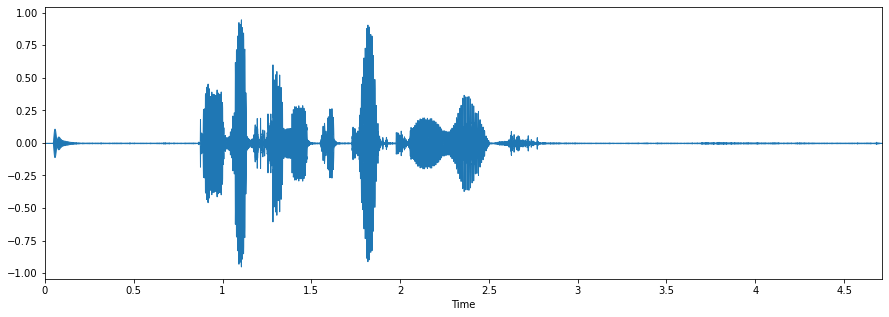

In [128]:
#plot new audio waveform
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

## Load in Model and Weights

In [129]:
#loading json and model architecture
json_file = open(
    '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/saved_models/cnn_model_json.json',
    'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

#load weights into new model
loaded_model.load_weights(
    "/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/saved_models/cnn_model_weights.h5"
)
print("Loaded model from disk")

#optimizer
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy',
                     optimizer=opt,
                     metrics=['accuracy'])

Loaded model from disk


In [130]:
#transform new audio file data
X, sample_rate = librosa.load(
    '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/test_audio/david_audio.wav',
    res_type='kaiser_fast',
    duration=2.5,
    sr=44100,
    offset=0.5)

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
male_audio_test = pd.DataFrame(data=mfccs).T
male_audio_test

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-30.930569,-30.289686,-30.906786,-30.407681,-29.200552,-31.198656,-31.440767,-34.022785,-33.517738,-33.99852,...,-30.566347,-31.499786,-31.232845,-28.877789,-27.284534,-26.970629,-27.412479,-28.270613,-27.229622,-25.618242


In [131]:
#transform another new audio file data
X2, sample_rate2 = librosa.load(
    '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/test_audio/female_audio.wav',
    res_type='kaiser_fast',
    duration=2.5,
    sr=44100,
    offset=0.5)

sample_rate2 = np.array(sample_rate2)
mfccs2 = np.mean(librosa.feature.mfcc(y=X2, sr=sample_rate2, n_mfcc=13),
                 axis=0)
female_audio_test = pd.DataFrame(data=mfccs2).T
female_audio_test

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-26.9734,-26.970873,-26.677168,-26.707214,-26.466196,-25.227337,-27.004616,-28.527426,-28.639721,-29.060444,...,-23.500553,-20.789135,-22.028166,-21.021008,-19.681591,-21.331625,-20.618717,-20.087315,-14.071172,-7.597806


## Model Prediction

In [132]:
#model prediction
male_audio_test = np.expand_dims(male_audio_test, axis=2)
male_audio_test = loaded_model.predict(male_audio_test,
                                       batch_size=16,
                                       verbose=1)

1/1 [==============================] - 0s 1000us/step


In [133]:
#map model prediction to saved label
filename = '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/saved_models/emotion_speech_labels'
infile = open(filename, 'rb')
lb = pickle.load(infile)
infile.close()

#final predicted label
final_label = male_audio_test.argmax(axis=1)
final_label = final_label.astype(int).flatten()
final_label = (lb.inverse_transform((final_label)))
print(final_label)

['male_sad']


In [134]:
#model prediction2
female_audio_test = np.expand_dims(female_audio_test, axis=2)
female_audio_test = loaded_model.predict(female_audio_test,
                                         batch_size=16,
                                         verbose=1)

1/1 [==============================] - 0s 1ms/step


In [135]:
#map model prediction to saved label
filename = '/Users/davidweon/davids_repo/projects/project5_speech_emotion/notebooks/saved_models/emotion_speech_labels'
infile = open(filename, 'rb')
lb = pickle.load(infile)
infile.close()

#final predicted label2
final_label2 = female_audio_test.argmax(axis=1)
final_label2 = final_label2.astype(int).flatten()
final_label2 = (lb.inverse_transform((final_label2)))
print(final_label2)

['female_sad']


## Speech to Text

In [136]:
import speech_recognition as sr

r = sr.Recognizer()

In [137]:
#male_audio_test speech to text
david = sr.AudioFile('test_audio/david_audio.wav')
with david as source:
    audio = r.record(source)

type(audio)

speech_recognition.AudioData

In [138]:
r.recognize_google(audio)

'David I need to talk to you right now'

In [139]:
#female_audio_test speech to text
esther = sr.AudioFile('test_audio/female_audio.wav')
with esther as source:
    audio2 = r.record(source)

r.recognize_google(audio2)

'wow David did you hear the news'